Skip the first two steps if you've already ran them and simply need to continue downloading images

In [1]:
import math
import random
import os
import numpy as np
import pandas as pd
from osgeo import gdal, osr
from tqdm.notebook import tqdm

import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [2]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage, misc
#import cStringIO
from io import StringIO
import io
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
%matplotlib inline
import urllib
import pandas as pd
import numpy as np

# map
import folium
from ipyleaflet import Map, basemaps, basemap_to_tiles
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import LineString, Point
import contextily

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
BASE_DIR = '..'
#COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
COUNTRIES_DIR = os.path.join(BASE_DIR, 'gdelt')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
#ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'planet_api_key.txt')
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'google_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

#25a47d4c6b784a589719cde6b282d2d2

In [4]:
import sys
sys.path.append(BASE_DIR)
from utils import create_space

In [20]:
base_map = generateBaseMap([center_x, center_y], 8,1000,1000)
folium.plugins.HeatMap(data=df[['cluster_lat', 'cluster_lon', 'nightlights']]
                       .groupby(['cluster_lat', 'cluster_lon']).sum().reset_index().values.tolist()
                       , radius=10, max_zoom=10).add_to(base_map)
print('Average Night Light Luminosity')
base_map

Average Night Light Luminosity


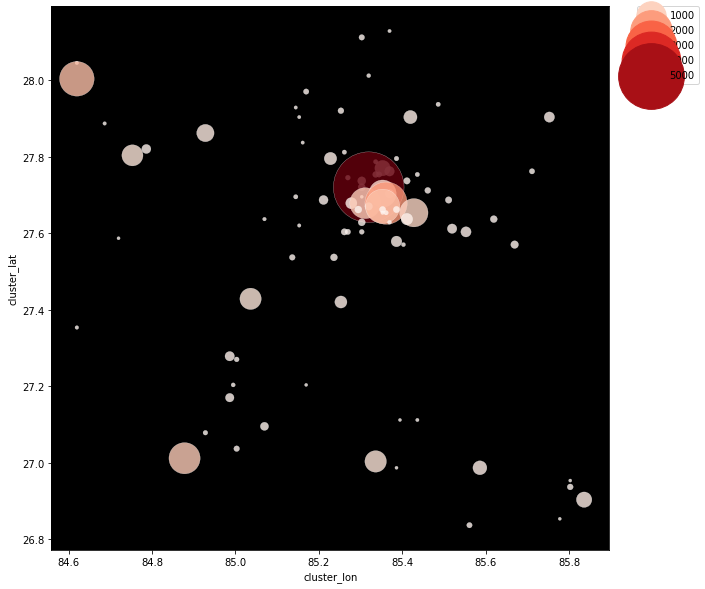

In [22]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(y='cluster_lat', x='cluster_lon', alpha=0.8,
                size='Noofprotest', palette='Reds', 
                hue='Noofprotest', sizes=(10, 5000), 
                data=df)

g.patch.set_facecolor('black')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

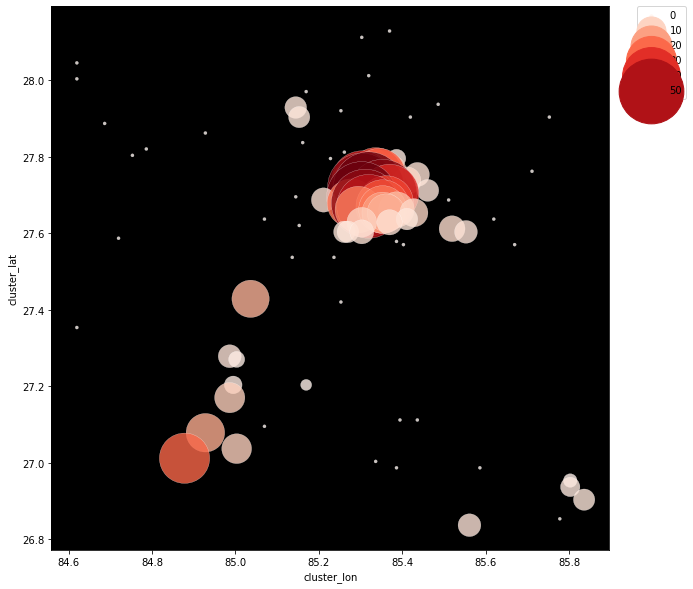

In [23]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(y='cluster_lat', x='cluster_lon', alpha=0.8,
                size='nightlights', palette='Reds', 
                hue='nightlights', sizes=(10, 5000), 
                data=df)

g.patch.set_facecolor('black')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [26]:
df_mw_pd = geopandas.GeoDataFrame(df, 
                                         geometry = geopandas.points_from_xy(df['cluster_lon'], df['cluster_lat']))

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


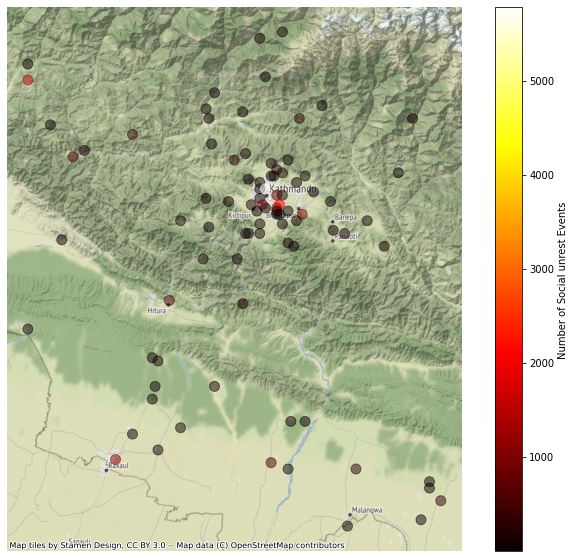

In [30]:
#df_dhs_light_pd.to_crs(epsg=4326)
df_mw_pd.crs = {'init' :'epsg:4326'}

lgnd_kwds = {'label': 'Number of Social unrest Events '}

ax_clusters_1 = df_mw_pd.to_crs(epsg=3857).plot(column = 'Noofprotest', 
                                                     legend=True, legend_kwds=lgnd_kwds, alpha=0.5,
                                                     figsize=(12, 10), markersize = 100, cmap='hot')

#contextily.add_basemap(ax_clusters_1, url=contextily.sources.ST_TERRAIN_BACKGROUND)
contextily.add_basemap(ax_clusters_1, url=contextily.providers.NASAGIBS.ViirsEarthAtNight2012)
ax_clusters_1.set_axis_off()
plt.show()

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


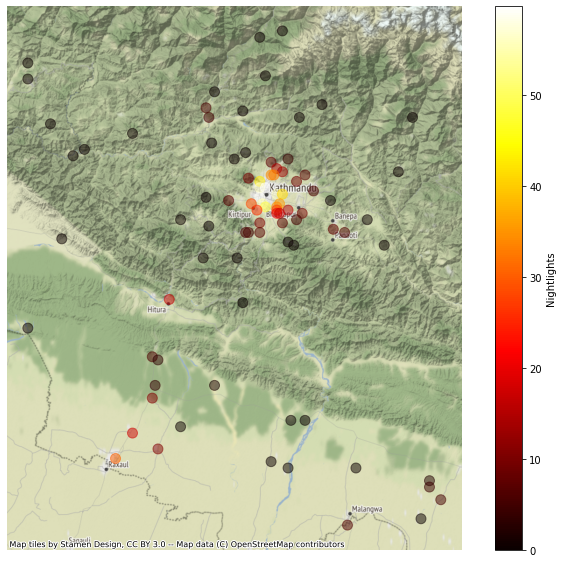

In [29]:
#df_dhs_light_pd.to_crs(epsg=4326)
df_mw_pd.crs = {'init' :'epsg:4326'}

lgnd_kwds = {'label': 'Nightlights'}

ax_clusters_1 = df_mw_pd.to_crs(epsg=3857).plot(column = 'nightlights', 
                                                     legend=True, legend_kwds=lgnd_kwds, alpha=0.5,
                                                     figsize=(12, 10), markersize = 100, cmap='hot')

#contextily.add_basemap(ax_clusters_1, url=contextily.sources.ST_TERRAIN_BACKGROUND)
contextily.add_basemap(ax_clusters_1, url=contextily.providers.NASAGIBS.ViirsEarthAtNight2012)
ax_clusters_1.set_axis_off()
plt.show()

In [45]:
df_pred = pd.read_csv("predicted_protest.csv")

In [49]:
df_pred['pred_protest'] =round(df_pred['0']/25)

In [47]:
df_pred['0'].values[df_pred['0'] <0] =0

In [50]:
df_pred.describe()

,cluster_lat,cluster_lon,Noofprotest,consumervalue,feat_index,0,pred_protest
count,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000,4409.000000
mean,27.518878,85.266084,25.711953,0.425428,2204.000000,146.121061,5.842141
std,0.391952,0.356932,374.965248,0.151858,1272.912998,138.069975,5.531180
min,26.778750,84.594580,0.000000,0.021400,0.000000,0.000000,0.000000
25%,27.170416,84.986250,0.000000,0.323900,1102.000000,11.917509,0.000000
50%,27.545416,85.269585,0.000000,0.411800,2204.000000,123.871749,5.000000
75%,27.853750,85.569580,0.000000,0.510700,3306.000000,231.025491,9.000000
max,28.237083,85.886250,5577.000000,1.000000,4408.000000,982.654098,39.000000


In [51]:
df_mw_pd1 = geopandas.GeoDataFrame(df_pred, 
                                         geometry = geopandas.points_from_xy(df_pred['cluster_lon'], df_pred['cluster_lat']))

In [ ]:
#df_dhs_light_pd.to_crs(epsg=4326)
df_mw_pd1.crs = {'init' :'epsg:4326'}

lgnd_kwds = {'label': 'Number of Social unrest Events-Predicted '}

ax_clusters_1 = df_mw_pd1.to_crs(epsg=3857).plot(column = '0', 
                                                     legend=True, legend_kwds=lgnd_kwds, alpha=0.5,
                                                     figsize=(12, 10), markersize = 100, cmap='hot')

#contextily.add_basemap(ax_clusters_1, url=contextily.sources.ST_TERRAIN_BACKGROUND)
contextily.add_basemap(ax_clusters_1, url=contextily.providers.NASAGIBS.ViirsEarthAtNight2012)
ax_clusters_1.set_axis_off()
plt.show()

/home/samal/poudelnish/.conda/envs/aanisha/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [56]:
from folium import plugins
from folium.plugins import HeatMap

base_map = generateBaseMap([center_x, center_y], 10, 1000, 1000)
folium.plugins.HeatMap(data=df_pred[['cluster_lat', 'cluster_lon', '0']]
                       .groupby(['cluster_lat', 'cluster_lon']).sum().reset_index().values.tolist()
                       , radius=10, max_zoom=10).add_to(base_map)
print('No of protest score')
base_map

No of protest score


In [62]:
from folium import plugins
from folium.plugins import HeatMap

base_map = generateBaseMap([center_x, center_y], 10, 1000, 1000)
folium.plugins.HeatMap(data=df_pred[['cluster_lat', 'cluster_lon', 'consumervalue']]
                       .groupby(['cluster_lat', 'cluster_lon']).sum().reset_index().values.tolist()
                       , radius=10, max_zoom=10).add_to(base_map)
print('No of protest score')
base_map

No of protest score


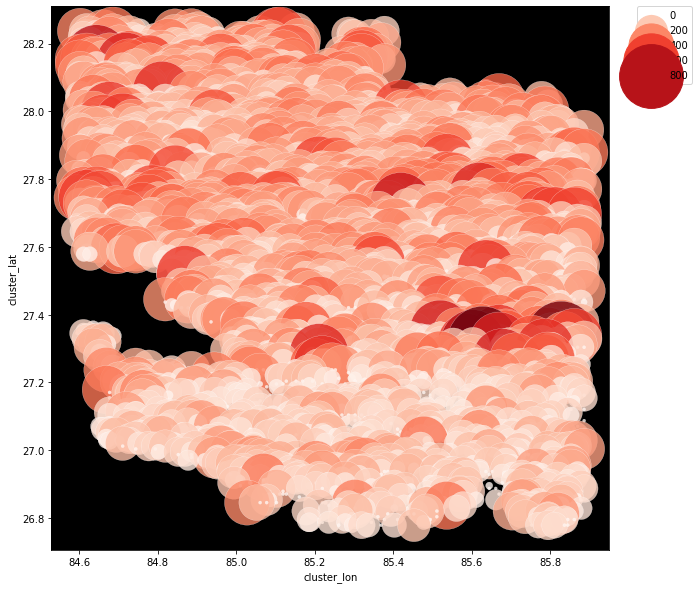

In [59]:
plt.figure(figsize=(10,10))
g = sns.scatterplot(y='cluster_lat', x='cluster_lon', alpha=0.8,
                size='0', palette='Reds', 
                hue='0', sizes=(10, 5000), 
                data=df_pred)

g.patch.set_facecolor('black')
g.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)